# Multimodal Funnel
### Notebook
---

In [1]:
using Revise, DrWatson
@quickactivate "ra-hmc"

In [7]:
using main
using Plots, Random, Distributions, Revise, ProgressMeter
using Flux, DynamicPPL, Zygote, ForwardDiff, Optim

gr()
theme(:default)
default(fmt=:png, levels=10, lw=0.1, msw=0.5, la=0.1, xguidefontsize=9, tickfontsize=7)
ProgressMeter.ijulia_behavior(:clear);

#### Functions for generating plots

In [8]:
@model function funnel(d, c=20.0)
    μ = -3c
    σ = 2.0
    y ~ MixtureModel([Normal(μ + 5.0, σ), Normal(-μ - 5.0, σ)])
    x ~ MixtureModel([
            MvNormal(
                20x_ * ones(d - 1), 
                0.1 * exp(sign(x_) * 1 * (y/2 - sign(x_) * 0.1μ + x_))
            ) for x_ in [-c, +c]
        ])
end

funnel (generic function with 3 methods)

In [9]:
function model(d=2, c=20.0)
    ℓ(x) = logjoint(funnel(d, c), (; x=x[1:end-1], y=x[end]))
    U(x) = isfinite(ℓ(x)) ? -ℓ(x) : 1e200
    dU(x) = ForwardDiff.gradient(U, x)
    f(x) = max(exp(-U(x)), 1e-200)
    g(x) = ForwardDiff.gradient(f, x)
    return main.Model(ξ=Normal(d, 1.0), d=d, f=f, g=g, U=U, dU=dU)
end

model (generic function with 3 methods)

In [10]:
using LinearAlgebra

function prior(n)
    return [rand(funnel(2, c)) |> Iterators.flatten |> collect |> reverse for _ in 1:n] |> a2m
end

function bures(m1, m2, s1, s2)
    a = norm(m1 - m2)^2
    b = tr(sqrt(sqrt(s1) * s2 * sqrt(s1)))
    c = tr(s1) + tr(s2) - 2 * b
    return sqrt(a + c)
end

function w2(x; times=100)
    res = zeros(times)
    @showprogress for i in 1:times
        y = prior(5000)
        res[i] = bures(mean(x, dims=1), mean(y, dims=1), cov(x), cov(y))
    end
    return mean(res)
end

w2 (generic function with 1 method)

In [11]:
function plt(m=model(2), exts=[(-50, 50), (-30, 30)], len=500, cls=palette(:linear_wcmr_100_45_c42_n256, 100); levels=10, t=false, kwargs...)
    return contourf(
        range(exts[1]..., length=len),
        range(exts[2]..., length=len),
        # (x, y) -> m.f([x; y])^(2e-1), c=cls,
        (x, y) -> t ? -(m.U([x; y])) : m.f([x; y])^(1e-1), 
        c=cls,
        fa=0.25,
        levels=levels; kwargs...
    )
end

function scatterplot(x, baseplt=nothing; kwargs...)
    if !isnothing(baseplt)
        p = plot(baseplt)
    else
        p = plot(x -> 0, 0.01, 0.02, la=0, lw=0, c=:white)
    end
    if typeof(x) <: Tuple
        marker_size = exp.(2 .* standardize(UnitRangeTransform, x[2]))
        p = plot(p, Tuple.(eachrow(x[1])); c=:black, lw=0.1, la=0.5, label="")
        p = scatter(p, Tuple.(eachrow(x[1])); ms=marker_size, c=:darkorange, kwargs...)
    else
        p = plot(p, Tuple.(eachrow(x)); c=:black, lw=0.1, la=0.5, label="")
        p = scatter(p, Tuple.(eachrow(x)); c=:darkorange, kwargs...)
    end
    return p
end

plt(lims) = plt(m, lims, levels=15, t=false, grid=false, fa=1.0)

plt (generic function with 5 methods)

---

# Multimodal Funnel

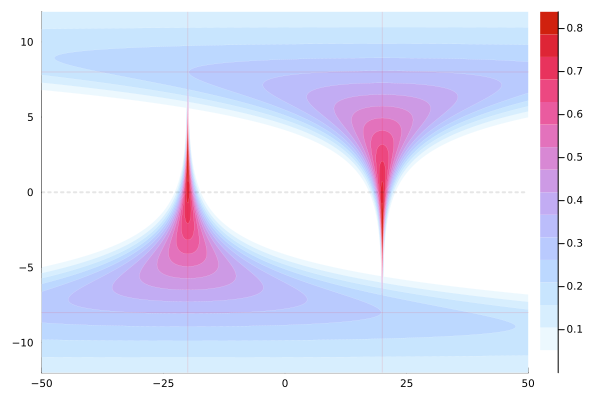

In [12]:
c = 1.0
m = model(2, 1.0)


pltlims = [((-50, 50), (-12, 12)), ((-50, 10), (-12, 9)),((-10, 50), (-9, 12))]
plt(pltlims[1])
vline!([-c, c] .* 20, lw=1, label="", c=:red)
hline!([-c, c] .* 3 .+ [-5, 5], lw=1, label="", c=:red)
hline!([0], lw=2, c=:black, ls=:dot, label="")

---

## 1. HMC

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
  HMC(0.18093855957991722, 55, Any[]):  0.42711457708458306


Acceptance Ratio = 0.4271
 14.768993 seconds (59.94 M allocations: 2.909 GiB, 4.78% gc time, 49.43% compilation time: 1% of which was recompilation)


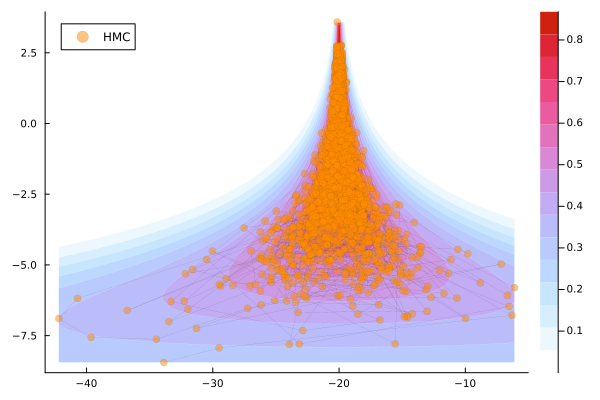

In [13]:
@time s1, a1 = mcmc(
    DualAverage(λ=10.0, δ=0.6), main.HMC(),
    m; n=5e3, n_burn=1e3
)
x_hmc = s1[a1, :]
lims = extrema.(eachcol(x_hmc))
scatterplot(x_hmc, plt(lims), msw=0.1, ma=0.5, label="HMC")

---

## 2. RA-HMC

Progress: 100%|█████████████████████████████████████████| Time: 0:18:17
  RAHMC(0.005483661371469341, 5471, 0.10838752994489737, Any[]):  0.22255548890221954


Acceptance Ratio = 0.2226
1097.191148 seconds (6.59 G allocations: 312.826 GiB, 5.79% gc time)


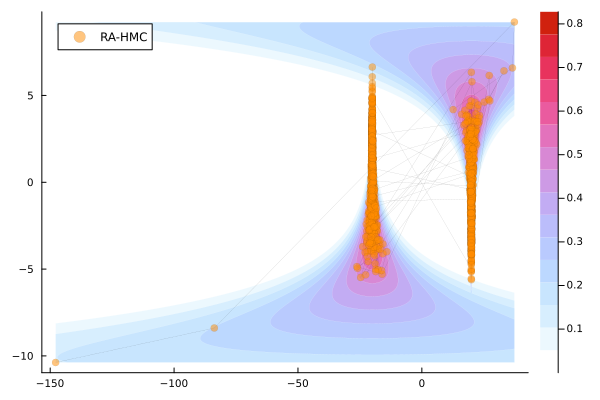

In [15]:
@time s2, a2 = mcmc(
    DualAverage(λ=30.0, δ=0.6), RAHMC(),
    m; n=5e3, n_burn=1e2
)

x_rahmc = s2[a2, :]
lims = extrema.(eachcol(x_rahmc))
scatterplot(x_rahmc, plt(lims), msw=0.1, ma=0.5, label="RA-HMC")

---

## 3. RAM

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  RAM(ZeroMeanIsoNormal(
dim: 2
μ: Zeros(2)
Σ: [100.0 0.0; 0.0 100.0]
)
, [0.398953625747188, -0.1385675518876923], Any[]):       0.05732377937010498


Acceptance Ratio = 0.053
  0.762815 seconds (7.23 M allocations: 277.851 MiB, 8.98% gc time)


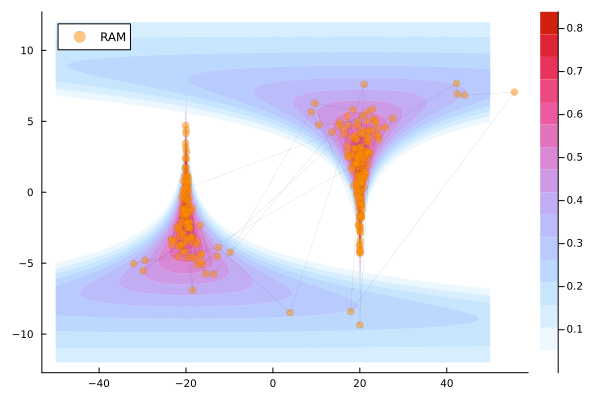

In [19]:
@time s3, a3 = mcmc(
    RAM(kernel=MvNormal(m.d, 10.0), z=randn(m.d)),
    m; n=5e3, n_burn=1e3
)
x_ram = s3[a3, :];
lims = extrema.(eachcol(x_ram))
scatterplot(x_ram, plt(pltlims[1]), msw=0.1, ma=0.5, label="RAM")


---

## 5. Wormhole HMC

Progress: 100%|█████████████████████████████████████████| Time: 0:01:57
  WHMC:  0.9498200719712115


Acceptance Ratio = 0.9498
117.589656 seconds (693.57 M allocations: 27.858 GiB, 4.40% gc time, 0.04% compilation time)


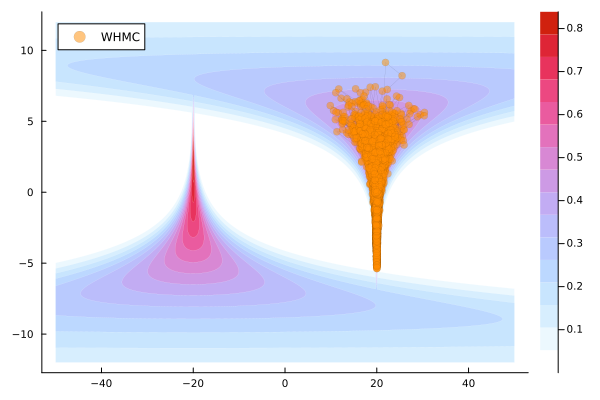

In [21]:
whmc_opt = WHMCOpt(method=LBFGS(), max_iter=20_000, temp=100.0)

@time s5, a5 = mcmc(
    WHMC(opt=whmc_opt, ϵ=0.05, L=100, k=1_000),
    m; n = 5e3, n_burn = 1e3
)
x_whmc = s5[a5, :];
lims = extrema.(eachcol(x_whmc))
scatterplot(x_whmc, plt(pltlims[1]), msw=0.1, ma=0.5, label="WHMC")

---

### Comparisons

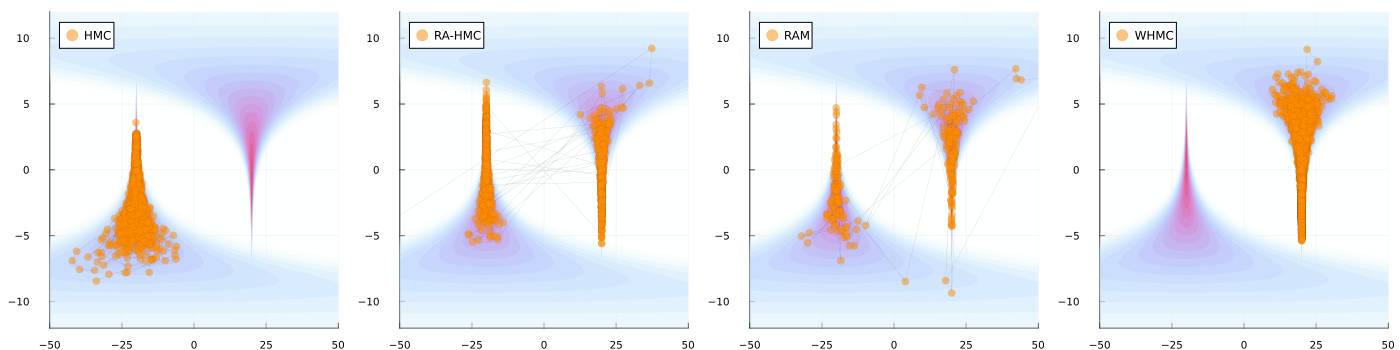

In [23]:
baseplt = plt(m, pltlims[1], levels=20)
pars = (; msw=0.1, ma=0.5, colorbar=false, xlim=pltlims[1][1], ylim=pltlims[1][2])

p1 = scatterplot(x_hmc, baseplt; label="HMC", pars...)
p2 = scatterplot(x_rahmc, baseplt; label="RA-HMC", pars...)
p3 = scatterplot(x_ram, baseplt; label="RAM", pars...)
p4 = scatterplot(x_whmc, baseplt; label="WHMC", pars...)
plot(p1, p2, p3, p4, layout=(1, 4), size=(1400, 350))

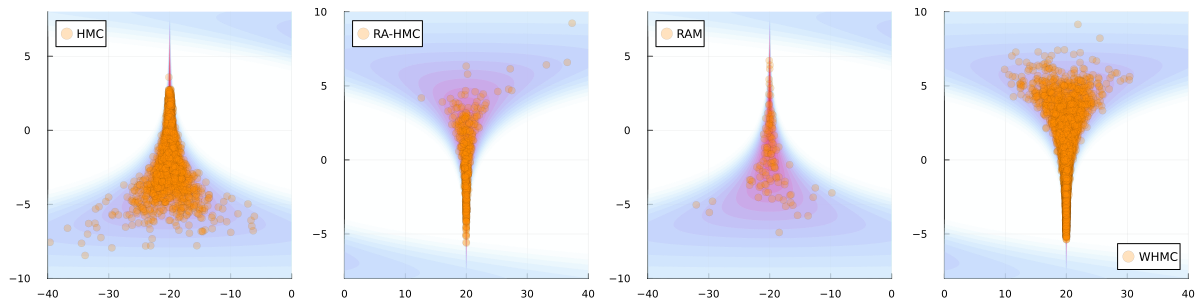

In [27]:
xs = [x_hmc, x_rahmc, x_ram, x_whmc]
names = ["HMC", "RA-HMC", "RAM", "WHMC"]
lims = [
    ((-40, 0), (-10, 8)),
    ((0, 40), (-8, 10))
]

bplt(i) = plt(m, lims[i], levels=20)
zoom_plt(x, i; kwargs...) = scatter(
    bplt(i), x |> m2t,
    msw=0.25, ma=0.25, c=:darkorange,
    xlim=lims[i][1], ylim=lims[i][2], cb=false; kwargs...
)

plot(map((x, lab, i) -> zoom_plt(x, i, label=lab), xs, names, [1, 2, 1, 2])..., layout=(1, 4), size=(1200, 300))

In [28]:
w2.(xs)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


4-element Vector{Float64}:
 26.82379878053847
  1.5191125415424416
  4.290374024278891
 27.38366273387117

---

In [48]:
plot(p1, p2, p3, p4, layout=(1, 4), size=(1400, 350),
fa=1.0, msa=0.9, msw=1.0, mc=:black
)
savefig(plotsdir("funnel/all.pdf"))

"/storage/work/s/suv87/julia/ra-hmc/plots/funnel/all.pdf"

In [47]:
plot(map((x, lab, i) -> zoom_plt(x, i, label=lab), xs, names, [1, 2, 1, 2])..., layout=(1, 4), size=(1200, 300), 
    fa=1.0, msa=0.9, msw=1.0, mc=:black
)
savefig(plotsdir("funnel/all_zoom.pdf"))

"/storage/work/s/suv87/julia/ra-hmc/plots/funnel/all_zoom.pdf"

In [ ]:
p = plt(pltlims[1])
savefig(plot(p, size=(400, 350)), plotsdir("funnel/contour.pdf"))

"/storage/work/s/suv87/julia/ra-hmc/plots/funnel/contour.pdf"